In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [9]:
from torchvision.datasets import ImageFolder

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [16]:
data_dir = "D:/Jayanth/Desktop/Data"

image_datasets = {'train': ImageFolder(data_dir, transform = data_transforms['train']),
                  'val': ImageFolder(data_dir, transform = data_transforms['val'])}
                 

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

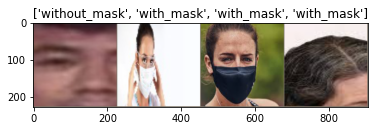

In [18]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss= []
    train_acc = []
    val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Transfer Learning using RESNET18**

In [29]:
model_ft = models.resnet18(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)


Epoch 0/14
----------
train Loss: 0.5070 Acc: 0.7907
val Loss: 0.0644 Acc: 0.9795

Epoch 1/14
----------
train Loss: 0.4665 Acc: 0.8195
val Loss: 0.0780 Acc: 0.9717

Epoch 2/14
----------
train Loss: 0.4749 Acc: 0.8193
val Loss: 0.0598 Acc: 0.9799

Epoch 3/14
----------
train Loss: 0.5058 Acc: 0.8046
val Loss: 0.0791 Acc: 0.9703

Epoch 4/14
----------
train Loss: 0.4790 Acc: 0.8232
val Loss: 0.0906 Acc: 0.9669

Epoch 5/14
----------
train Loss: 0.4854 Acc: 0.8145
val Loss: 0.0594 Acc: 0.9791

Epoch 6/14
----------
train Loss: 0.5029 Acc: 0.8064
val Loss: 0.0599 Acc: 0.9799

Epoch 7/14
----------
train Loss: 0.3507 Acc: 0.8560
val Loss: 0.0563 Acc: 0.9803

Epoch 8/14
----------
train Loss: 0.3487 Acc: 0.8546
val Loss: 0.0558 Acc: 0.9824

Epoch 9/14
----------
train Loss: 0.3493 Acc: 0.8518
val Loss: 0.0580 Acc: 0.9811

Epoch 10/14
----------
train Loss: 0.3358 Acc: 0.8520
val Loss: 0.0662 Acc: 0.9793

Epoch 11/14
----------
train Loss: 0.3431 Acc: 0.8485
val Loss: 0.0760 Acc: 0.9747

Ep

In [32]:
train_loss = [0.5070,0.4665, 0.4749, 0.5058, 0.4790,0.4854,0.5029,0.3507, 0.3487,0.3493,0.3358,0.3431,0.3365, 0.3266,0.3178]
val_loss = [0.0644,0.0780,0.0598, 0.0791,0.0906,0.0594,0.0599,0.0563,0.0558,0.0580,0.0662,0.0760,0.0603,0.0564,0.0664]

Text(0.5, 1.0, 'Train vs validation Losses')

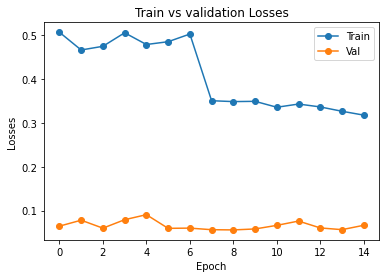

In [33]:
plt.plot(train_loss,'-o')
plt.plot(val_loss,'-o')
plt.xlabel('Epoch')

plt.ylabel('Losses')
plt.legend(['Train','Val'])
plt.title('Train vs validation Losses')

In [34]:
train_acc= [0.7907,0.8195, 0.8193,0.8046,0.8232,0.8145,0.8064,0.8560, 0.8546,0.8518,0.8520,0.8485,0.8463,0.8554,0.8638]
val_acc=[0.9795,0.9717,0.9799,0.9703,0.9669,0.9791, 0.9799,0.9803,0.9824,0.9811,0.9793,0.9747, 0.9804,0.9827,0.9786]




Text(0.5, 1.0, 'Train vs validation Accuracy')

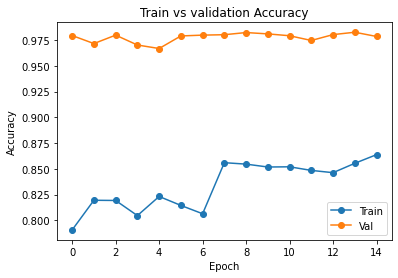

In [63]:
plt.plot(train_acc,'-o')
plt.plot(val_acc,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Train vs validation Accuracy')

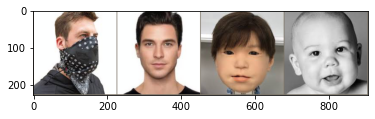

Actual Labels: with_mask  without_mask  without_mask  without_mask


In [53]:
dataiter = iter(dataloaders['val'])
images,label = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('Actual Labels:', '  '.join(class_names[label[j]] for j in range(4)))

In [54]:
output = model_ft(images)
_, predicted = torch.max(output.data,1)

print('Predicted Labels', '  '.join(class_names[predicted[j]] for j in range(4)))

Predicted Labels with_mask  without_mask  without_mask  without_mask


**Transfer Learning using VGG16**

In [61]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

num_ftrs = vgg16.classifier[6].in_features

vgg16.classifier[-1] = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [62]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)


Epoch 0/14
----------
train Loss: 0.2496 Acc: 0.9171
val Loss: 0.0533 Acc: 0.9823

Epoch 1/14
----------
train Loss: 0.2642 Acc: 0.9235
val Loss: 0.0389 Acc: 0.9876

Epoch 2/14
----------
train Loss: 0.3079 Acc: 0.9191
val Loss: 0.0886 Acc: 0.9755

Epoch 3/14
----------
train Loss: 0.2847 Acc: 0.9257
val Loss: 0.0283 Acc: 0.9915

Epoch 4/14
----------
train Loss: 0.3176 Acc: 0.9215
val Loss: 0.0267 Acc: 0.9926

Epoch 5/14
----------
train Loss: 0.3054 Acc: 0.9224
val Loss: 0.0290 Acc: 0.9914

Epoch 6/14
----------
train Loss: 0.3267 Acc: 0.9216
val Loss: 0.0389 Acc: 0.9891

Epoch 7/14
----------
train Loss: 0.2821 Acc: 0.9309
val Loss: 0.0242 Acc: 0.9929

Epoch 8/14
----------
train Loss: 0.2612 Acc: 0.9308
val Loss: 0.0226 Acc: 0.9938

Epoch 9/14
----------
train Loss: 0.2450 Acc: 0.9333
val Loss: 0.0216 Acc: 0.9929

Epoch 10/14
----------
train Loss: 0.2430 Acc: 0.9306
val Loss: 0.0212 Acc: 0.9932

Epoch 11/14
----------
train Loss: 0.2138 Acc: 0.9349
val Loss: 0.0201 Acc: 0.9934

Ep

In [64]:
train_loss = [0.2496,  0.2642,0.3079,.2847,0.3176, 0.3054,0.3267 ,0.2821,0.2612,0.2450,0.2430, 0.2138, 0.2082, 0.1920, 0.1962]

val_loss = [0.0533, 0.0389,0.0886, 0.0283,0.0267,0.0290,0.0242, 0.0389 , 0.0242,0.0226,0.0216, 0.0212,0.0201,0.0218,0.0202, 0.0200 ]


In [65]:

train_acc = [0.9171, 0.9235,0.9191,0.9257,0.9215, 0.9224, 0.9216,0.9309,0.9308, 0.9333,0.9306,0.9349,0.9364,0.9388, 0.9388]
val_acc =[0.9823, 0.9876, 0.9755,0.9915,0.9926, 0.9914, 0.9891, 0.9929,0.9938, 0.9929,0.9932,0.9934,0.9932,0.9938,0.9938]   

Text(0.5, 1.0, 'Train vs validation loss')

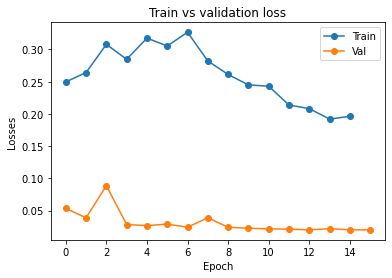

In [66]:
plt.plot(train_loss,'-o')
plt.plot(val_loss,'-o')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Train','Val'])
plt.title('Train vs validation loss')

Text(0.5, 1.0, 'Train vs validation Accuracy')

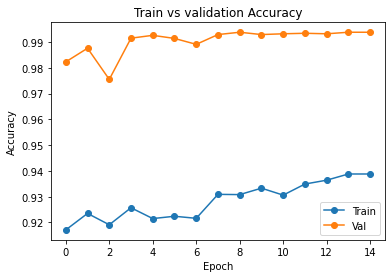

In [67]:
plt.plot(train_acc,'-o')
plt.plot(val_acc,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Train vs validation Accuracy')

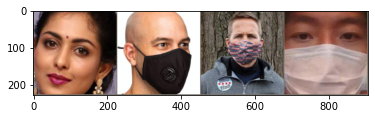

Actual Labels: without_mask  with_mask  with_mask  with_mask


In [68]:
dataiter = iter(dataloaders['val'])
images,label = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('Actual Labels:', '  '.join(class_names[label[j]] for j in range(4)))

In [71]:
output = vgg16(images)
_, predicted = torch.max(output.data,1)

print('Predicted Labels', '  '.join(class_names[predicted[j]] for j in range(4)))

Predicted Labels without_mask  with_mask  with_mask  with_mask
